In [7]:
import os, sys, math, pickle, time
from zmqRemoteApi import RemoteAPIClient
import pandas as pd
import numpy as np

from random import randint as ri
from random import uniform as ru

from keras.models import Sequential
from keras.layers import Dense
from keras.losses import Huber
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler


In [154]:
file = open("training_dataset_23000.pkl", "rb")
training_data = pickle.load(file)
training_df = pd.DataFrame(training_data)
training_df

,sequence,step,increments,prev_j_positions,prev_j_velocities,prev_j_forces,prev_base_pos_x,prev_base_pos_y,prev_base_pos_z,prev_base_ori_alpha,...,prev_base_ori_gamma,post_j_positions,post_j_velocities,post_j_forces,post_base_pos_x,post_base_pos_y,post_base_pos_z,post_base_ori_alpha,post_base_ori_beta,post_base_ori_gamma
0,0,0,"[-0.12613042184979575, 0.0592668035715147, -0....","[-0.0004229545593261719, 1.5691816806793213, -...","[0.020885471254587173, 0.028228765353560448, -...","[-0.013019926846027374, 0.18578627705574036, -...",0.117835,0.000000,0.000000,-0.000012,...,0.000309,"[-0.12137269973754883, 1.571723222732544, -0.0...","[0.10323534160852432, 0.019836444407701492, -0...","[0.17346760630607605, 1.594848871231079, -0.19...",-0.003347,-0.000953,0.117979,-0.000043,0.000127,0.033461
1,0,1,"[-0.002215149549820688, -0.059729389948448, 0....","[-0.12137269973754883, 1.571723222732544, -0.0...","[0.10323534160852432, 0.019836444407701492, -0...","[0.17346760630607605, 1.594848871231079, -0.19...",-0.003347,-0.000953,0.117979,-0.000043,...,0.033461,"[-0.12466669082641602, 1.5295994281768799, -0....","[-0.040054358541965485, -0.13809217512607574, ...","[0.010159922763705254, 0.560469925403595, -0.1...",-0.000470,0.001464,0.118195,-0.000639,-0.003768,0.022066
2,0,2,"[-0.018971973123591394, 0.10377103818132309, -...","[-0.12466669082641602, 1.5295994281768799, -0....","[-0.040054358541965485, -0.13809217512607574, ...","[0.010159922763705254, 0.560469925403595, -0.1...",-0.000470,0.001464,0.118195,-0.000639,...,0.022066,"[-0.15184307098388672, 1.5713598728179932, -0....","[0.284958153963089, -0.358391135931015, 0.0739...","[-0.2337055504322052, 1.0434253215789795, 0.20...",0.004184,0.001625,0.118168,-0.001138,0.004763,0.029754
3,0,3,"[-0.0542045239396309, 0.022588666929305893, 0....","[-0.15184307098388672, 1.5713598728179932, -0....","[0.284958153963089, -0.358391135931015, 0.0739...","[-0.2337055504322052, 1.0434253215789795, 0.20...",0.004184,0.001625,0.118168,-0.001138,...,0.029754,"[-0.1974334716796875, 1.5711414813995361, -0.0...","[-0.3721717596054077, -0.1516343653202057, 0.2...","[0.2642908990383148, 1.0372412204742432, -0.27...",0.004422,0.000937,0.117889,0.000248,0.001124,0.029383
4,0,4,"[-0.03183826512909506, -0.01593833114281746, 0...","[-0.1974334716796875, 1.5711414813995361, -0.0...","[-0.3721717596054077, -0.1516343653202057, 0.2...","[0.2642908990383148, 1.0372412204742432, -0.27...",0.004422,0.000937,0.117889,0.000248,...,0.029383,"[-0.2280290126800537, 1.5633528232574463, -0.0...","[0.07843978703022003, -0.02803805097937584, 0....","[0.0790664404630661, 0.22813138365745544, -0.1...",0.005902,-0.003809,0.118557,0.002118,-0.006840,0.015049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,9,5,"[-0.1243372086972623, 0.03931302949573513, -0....","[-0.15624761581420898, 1.4695465564727783, 0.1...","[0.13351134955883026, -0.28781232237815857, -1...","[1.24044930934906, 0.3904241919517517, -0.8407...",0.004063,-0.003778,0.118789,-0.002738,...,0.027573,"[-0.29192399978637695, 1.5127241611480713, 0.0...","[-0.1280755251646042, -0.2061796635389328, 0.2...","[0.8323136568069458, 0.4703407287597656, -0.83...",0.005249,-0.014535,0.119112,0.000956,0.004975,0.055432
96,9,6,"[-0.08875439214901354, -0.0943378596547181, 0....","[-0.29192399978637695, 1.5127241611480713, 0.0...","[-0.1280755251646042, -0.2061796635389328, 0.2...","[0.8323136568069458, 0.4703407287597656, -0.83...",0.005249,-0.014535,0.119112,0.000956,...,0.055432,"[-0.31340456008911133, 1.4411098957061768, -0....","[2.0815372467041016, 0.7814228534698486, -1.83...","[1.3389356136322021, 0.8472808599472046, -1.48...",0.010203,-0.013060,0.120240,-0.003346,0.013767,0.052450
97,9,7,"[-0.08557187392415336, 0.02227533597388373, -0...","[-0.31340456008911133, 1.4411098957061768, -0....","[2.0815372467041016, 0.7814228534698486, -1.83...","[1.3389356136322021, 0.8472808599472046, -1.48...",0.010203,-0.013060,0.120240,-0.003346,.

## Test function to load the training dataset into X,Y

In [10]:
file = open("training_dataset_23000.pkl", "rb")
training_data = pickle.load(file)

In [11]:
print(training_data[-1])

{'sequence': 9, 'step': 9, 'increments': [-0.004642471900218863, 0.06739293445281422, 0.10959912218685598, -0.04168192101310391, -0.028382338849293236, 0.11087720126895623, -0.12290649062736703, -0.024499178777003416], 'prev_j_positions': [-0.32297658920288086, 1.5154716968536377, -0.03591322898864746, 1.5717566013336182, -0.12015175819396973, 1.5112602710723877, -0.05147242546081543, 1.352480173110962], 'prev_j_velocities': [-1.365700125694275, 0.22186188399791718, -0.3719954192638397, -0.062380772083997726, -0.2276802808046341, -0.04521175101399422, 0.0684376209974289, -0.11865700036287308], 'prev_j_forces': [1.4294105768203735, 0.8379113078117371, -1.4259006977081299, 1.265397310256958, -0.005070046056061983, 0.031009897589683533, -0.019467882812023163, 0.08897878974676132], 'prev_base_pos_x': 0.006268832832574844, 'prev_base_pos_y': -0.024350816383957863, 'prev_base_pos_z': 0.119644895195961, 'prev_base_ori_alpha': 0.002636461751535535, 'prev_base_ori_beta': 0.006663693580776453, '

In [84]:
training_df = pd.DataFrame(training_data)
training_df

,sequence,step,increments,prev_j_positions,prev_j_velocities,prev_j_forces,prev_base_pos_x,prev_base_pos_y,prev_base_pos_z,prev_base_ori_alpha,...,prev_base_ori_gamma,post_j_positions,post_j_velocities,post_j_forces,post_base_pos_x,post_base_pos_y,post_base_pos_z,post_base_ori_alpha,post_base_ori_beta,post_base_ori_gamma
0,0,0,"[-0.12613042184979575, 0.0592668035715147, -0....","[-0.0004229545593261719, 1.5691816806793213, -...","[0.020885471254587173, 0.028228765353560448, -...","[-0.013019926846027374, 0.18578627705574036, -...",0.117835,0.000000,0.000000,-0.000012,...,0.000309,"[-0.12137269973754883, 1.571723222732544, -0.0...","[0.10323534160852432, 0.019836444407701492, -0...","[0.17346760630607605, 1.594848871231079, -0.19...",-0.003347,-0.000953,0.117979,-0.000043,0.000127,0.033461
1,0,1,"[-0.002215149549820688, -0.059729389948448, 0....","[-0.12137269973754883, 1.571723222732544, -0.0...","[0.10323534160852432, 0.019836444407701492, -0...","[0.17346760630607605, 1.594848871231079, -0.19...",-0.003347,-0.000953,0.117979,-0.000043,...,0.033461,"[-0.12466669082641602, 1.5295994281768799, -0....","[-0.040054358541965485, -0.13809217512607574, ...","[0.010159922763705254, 0.560469925403595, -0.1...",-0.000470,0.001464,0.118195,-0.000639,-0.003768,0.022066
2,0,2,"[-0.018971973123591394, 0.10377103818132309, -...","[-0.12466669082641602, 1.5295994281768799, -0....","[-0.040054358541965485, -0.13809217512607574, ...","[0.010159922763705254, 0.560469925403595, -0.1...",-0.000470,0.001464,0.118195,-0.000639,...,0.022066,"[-0.15184307098388672, 1.5713598728179932, -0....","[0.284958153963089, -0.358391135931015, 0.0739...","[-0.2337055504322052, 1.0434253215789795, 0.20...",0.004184,0.001625,0.118168,-0.001138,0.004763,0.029754
3,0,3,"[-0.0542045239396309, 0.022588666929305893, 0....","[-0.15184307098388672, 1.5713598728179932, -0....","[0.284958153963089, -0.358391135931015, 0.0739...","[-0.2337055504322052, 1.0434253215789795, 0.20...",0.004184,0.001625,0.118168,-0.001138,...,0.029754,"[-0.1974334716796875, 1.5711414813995361, -0.0...","[-0.3721717596054077, -0.1516343653202057, 0.2...","[0.2642908990383148, 1.0372412204742432, -0.27...",0.004422,0.000937,0.117889,0.000248,0.001124,0.029383
4,0,4,"[-0.03183826512909506, -0.01593833114281746, 0...","[-0.1974334716796875, 1.5711414813995361, -0.0...","[-0.3721717596054077, -0.1516343653202057, 0.2...","[0.2642908990383148, 1.0372412204742432, -0.27...",0.004422,0.000937,0.117889,0.000248,...,0.029383,"[-0.2280290126800537, 1.5633528232574463, -0.0...","[0.07843978703022003, -0.02803805097937584, 0....","[0.0790664404630661, 0.22813138365745544, -0.1...",0.005902,-0.003809,0.118557,0.002118,-0.006840,0.015049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,9,5,"[-0.1243372086972623, 0.03931302949573513, -0....","[-0.15624761581420898, 1.4695465564727783, 0.1...","[0.13351134955883026, -0.28781232237815857, -1...","[1.24044930934906, 0.3904241919517517, -0.8407...",0.004063,-0.003778,0.118789,-0.002738,...,0.027573,"[-0.29192399978637695, 1.5127241611480713, 0.0...","[-0.1280755251646042, -0.2061796635389328, 0.2...","[0.8323136568069458, 0.4703407287597656, -0.83...",0.005249,-0.014535,0.119112,0.000956,0.004975,0.055432
96,9,6,"[-0.08875439214901354, -0.0943378596547181, 0....","[-0.29192399978637695, 1.5127241611480713, 0.0...","[-0.1280755251646042, -0.2061796635389328, 0.2...","[0.8323136568069458, 0.4703407287597656, -0.83...",0.005249,-0.014535,0.119112,0.000956,...,0.055432,"[-0.31340456008911133, 1.4411098957061768, -0....","[2.0815372467041016, 0.7814228534698486, -1.83...","[1.3389356136322021, 0.8472808599472046, -1.48...",0.010203,-0.013060,0.120240,-0.003346,0.013767,0.052450
97,9,7,"[-0.08557187392415336, 0.02227533597388373, -0...","[-0.31340456008911133, 1.4411098957061768, -0....","[2.0815372467041016, 0.7814228534698486, -1.83...","[1.3389356136322021, 0.8472808599472046, -1.48...",0.010203,-0.013060,0.120240,-0.003346,.

In [82]:
increments_columns = []
prev_j_positions_columns = []
prev_j_velocities_columns = []
prev_j_forces_columns = []
post_j_positions_columns = []
post_j_velocities_columns = []
post_j_forces_columns = []
num_joints = len(training_data[-1]["increments"])
for joint_n in range(num_joints):
    #List to split inputs per joint
    joint_inc_col_name = "increments_" + str(joint_n)
    increments_columns.append(joint_inc_col_name)

    prev_joint_pos_col_name = "prev_j_positions_" + str(joint_n)
    prev_j_positions_columns.append(prev_joint_pos_col_name)

    prev_joint_vel_col_name = "prev_j_velocities_" + str(joint_n)
    prev_j_velocities_columns.append(prev_joint_vel_col_name)

    prev_joint_forc_col_name = "prev_j_forces_" + str(joint_n)
    prev_j_forces_columns.append(prev_joint_forc_col_name)
    #List to split outputs per joint
    post_joint_pos_col_name = "post_j_positions_" + str(joint_n)
    post_j_positions_columns.append(post_joint_pos_col_name)

    post_joint_vel_col_name = "post_j_velocities_" + str(joint_n)
    post_j_velocities_columns.append(post_joint_vel_col_name)

    post_joint_forc_col_name = "post_j_forces_" + str(joint_n)
    post_j_forces_columns.append(post_joint_forc_col_name)
print(increments_columns)
print(prev_j_positions_columns)
print(prev_j_velocities_columns)
print(prev_j_forces_columns)
print(post_j_positions_columns)
print(post_j_velocities_columns)
print(post_j_forces_columns)


['increments_0', 'increments_1', 'increments_2', 'increments_3', 'increments_4', 'increments_5', 'increments_6', 'increments_7']
['prev_j_positions_0', 'prev_j_positions_1', 'prev_j_positions_2', 'prev_j_positions_3', 'prev_j_positions_4', 'prev_j_positions_5', 'prev_j_positions_6', 'prev_j_positions_7']
['prev_j_velocities_0', 'prev_j_velocities_1', 'prev_j_velocities_2', 'prev_j_velocities_3', 'prev_j_velocities_4', 'prev_j_velocities_5', 'prev_j_velocities_6', 'prev_j_velocities_7']
['prev_j_forces_0', 'prev_j_forces_1', 'prev_j_forces_2', 'prev_j_forces_3', 'prev_j_forces_4', 'prev_j_forces_5', 'prev_j_forces_6', 'prev_j_forces_7']
['post_j_positions_0', 'post_j_positions_1', 'post_j_positions_2', 'post_j_positions_3', 'post_j_positions_4', 'post_j_positions_5', 'post_j_positions_6', 'post_j_positions_7']
['post_j_velocities_0', 'post_j_velocities_1', 'post_j_velocities_2', 'post_j_velocities_3', 'post_j_velocities_4', 'post_j_velocities_5', 'post_j_velocities_6', 'post_j_velocitie

In [80]:
increments_df = pd.DataFrame(training_df['increments'].to_list())
increments_df.columns = increments_columns
increments_df

,increments_0,increments_1,increments_2,increments_3,increments_4,increments_5,increments_6,increments_7
0,-0.126130,0.059267,-0.016787,0.067780,-0.115712,0.126173,-0.112338,0.116650
1,-0.002215,-0.059729,0.009223,0.035597,0.130856,-0.016162,0.053336,-0.010903
2,-0.018972,0.103771,-0.120704,-0.047342,0.083513,0.036392,0.002415,0.007654
3,-0.054205,0.022589,0.091175,0.072046,-0.085085,0.013351,0.070837,0.033416
4,-0.031838,-0.015938,0.019460,0.053888,0.074128,-0.114456,0.035428,0.027180
...,...,...,...,...,...,...,...,...
95,-0.124337,0.039313,-0.089462,0.098336,0.089739,-0.045167,-0.125761,-0.104647
96,-0.088754,-0.094338,0.010469,0.101213,-0.057183,0.005216,0.098524,-0.082037
97,-0.085572,0.022275,-0.006855,-0.062666,-0.028800,0.130003,-0.033344,0.078420
98,-0.021351,0.042924,0.087071,0.016588,0.091394,-0.112363,0.002340,-0.118202


In [70]:
training_data[1].keys()

dict_keys(['sequence', 'step', 'increments', 'prev_j_positions', 'prev_j_velocities', 'prev_j_forces', 'prev_base_pos_x', 'prev_base_pos_y', 'prev_base_pos_z', 'prev_base_ori_alpha', 'prev_base_ori_beta', 'prev_base_ori_gamma', 'post_j_positions', 'post_j_velocities', 'post_j_forces', 'post_base_pos_x', 'post_base_pos_y', 'post_base_pos_z', 'post_base_ori_alpha', 'post_base_ori_beta', 'post_base_ori_gamma'])

In [85]:
#Input columns per joint
increments_df = pd.DataFrame(training_df['increments'].to_list())
increments_df.columns = increments_columns
prev_j_positions_df = pd.DataFrame(training_df['prev_j_positions'].to_list())
prev_j_positions_df.columns = prev_j_positions_columns
prev_j_velocities_df = pd.DataFrame(training_df['prev_j_velocities'].to_list())
prev_j_velocities_df.columns = prev_j_velocities_columns
prev_j_forces_df = pd.DataFrame(training_df['prev_j_forces'].to_list())
prev_j_forces_df.columns = prev_j_forces_columns

#Output columns per joint
post_j_positions_df = pd.DataFrame(training_df['post_j_positions'].to_list())
post_j_positions_df.columns = post_j_positions_columns
post_j_velocities_df = pd.DataFrame(training_df['post_j_velocities'].to_list())
post_j_velocities_df.columns = post_j_velocities_columns
post_j_forces_df = pd.DataFrame(training_df['post_j_forces'].to_list())
post_j_forces_df.columns = post_j_forces_columns

In [93]:
X_df = pd.concat([increments_df, prev_j_positions_df, prev_j_velocities_df, prev_j_forces_df, 
                  training_df["prev_base_pos_x"], training_df["prev_base_pos_y"], training_df["prev_base_pos_z"], 
                  training_df["prev_base_ori_alpha"], training_df["prev_base_ori_beta"], training_df["prev_base_ori_gamma"]], 
                  axis="columns")
X_df

,increments_0,increments_1,increments_2,increments_3,increments_4,increments_5,increments_6,increments_7,prev_j_positions_0,prev_j_positions_1,...,prev_j_forces_4,prev_j_forces_5,prev_j_forces_6,prev_j_forces_7,prev_base_pos_x,prev_base_pos_y,prev_base_pos_z,prev_base_ori_alpha,prev_base_ori_beta,prev_base_ori_gamma
0,-0.126130,0.059267,-0.016787,0.067780,-0.115712,0.126173,-0.112338,0.116650,-0.000423,1.569182,...,-0.037023,-0.048595,-0.009998,0.219707,0.117835,0.000000,0.000000,-0.000012,0.000343,0.000309
1,-0.002215,-0.059729,0.009223,0.035597,0.130856,-0.016162,0.053336,-0.010903,-0.121373,1.571723,...,0.018792,1.341613,-0.019147,1.396770,-0.003347,-0.000953,0.117979,-0.000043,0.000127,0.033461
2,-0.018972,0.103771,-0.120704,-0.047342,0.083513,0.036392,0.002415,0.007654,-0.124667,1.529599,...,-0.166370,0.144133,0.168775,0.168932,-0.000470,0.001464,0.118195,-0.000639,-0.003768,0.022066
3,-0.054205,0.022589,0.091175,0.072046,-0.085085,0.013351,0.070837,0.033416,-0.151843,1.571360,...,-0.283657,1.092996,0.264683,1.117310,0.004184,0.001625,0.118168,-0.001138,0.004763,0.029754
4,-0.031838,-0.015938,0.019460,0.053888,0.074128,-0.114456,0.035428,0.027180,-0.197433,1.571141,...,0.306528,0.986640,-0.298266,1.385121,0.004422,0.000937,0.117889,0.000248,0.001124,0.029383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.124337,0.039313,-0.089462,0.098336,0.089739,-0.045167,-0.125761,-0.104647,-0.156248,1.469547,...,-0.107873,0.219920,0.110020,0.168989,0.004063,-0.003778,0.118789,-0.002738,-0.007970,0.027573
96,-0.088754,-0.094338,0.010469,0.101213,-0.057183,0.005216,0.098524,-0.082037,-0.291924,1.512724,...,0.008540,0.053093,-0.012446,0.219523,0.005249,-0.014535,0.119112,0.000956,0.004975,0.055432
97,-0.085572,0.022275,-0.006855,-0.062666,-0.028800,0.130003,-0.033344,0.078420,-0.313405,1.441110,...,-0.005127,1.024812,-0.023534,0.284702,0.010203,-0.013060,0.120240,-0.003346,0.013767,0.052450
98,-0.021351,0.042924,0.087071,0.016588,0.091394,-0.112363,0.002340,-0.118202,-0.340073,1.453215,...,0.026475,1.202122,0.024861,-0.027430,0.008740,-0.015095,0.119656,-0.002551,0.008873,0.055078


In [94]:
Y_df = pd.concat([post_j_positions_df, post_j_velocities_df, post_j_forces_df,
                  training_df["post_base_pos_x"], training_df["post_base_pos_y"], training_df["post_base_pos_z"], 
                  training_df["post_base_ori_alpha"], training_df["post_base_ori_beta"], training_df["post_base_ori_gamma"]], axis="columns")
Y_df

,post_j_positions_0,post_j_positions_1,post_j_positions_2,post_j_positions_3,post_j_positions_4,post_j_positions_5,post_j_positions_6,post_j_positions_7,post_j_velocities_0,post_j_velocities_1,...,post_j_forces_4,post_j_forces_5,post_j_forces_6,post_j_forces_7,post_base_pos_x,post_base_pos_y,post_base_pos_z,post_base_ori_alpha,post_base_ori_beta,post_base_ori_gamma
0,-0.121373,1.571723,-0.024122,1.572269,-0.114941,1.571113,-0.112529,1.574391,0.103235,0.019836,...,0.018792,1.341613,-0.019147,1.396770,-0.003347,-0.000953,0.117979,-0.000043,0.000127,0.033461
1,-0.124667,1.529599,-0.019385,1.575375,0.012445,1.560308,-0.057525,1.568798,-0.040054,-0.138092,...,-0.166370,0.144133,0.168775,0.168932,-0.000470,0.001464,0.118195,-0.000639,-0.003768,0.022066
2,-0.151843,1.571360,-0.131721,1.527573,0.087149,1.571229,-0.046512,1.571794,0.284958,-0.358391,...,-0.283657,1.092996,0.264683,1.117310,0.004184,0.001625,0.118168,-0.001138,0.004763,0.029754
3,-0.197433,1.571141,-0.046039,1.572434,0.007659,1.570915,0.013794,1.571103,-0.372172,-0.151634,...,0.306528,0.986640,-0.298266,1.385121,0.004422,0.000937,0.117889,0.000248,0.001124,0.029383
4,-0.228029,1.563353,-0.030708,1.572726,0.085051,1.487941,0.049216,1.571955,0.078440,-0.028038,...,0.101228,0.581781,-0.040017,1.132440,0.005902,-0.003809,0.118557,0.002118,-0.006840,0.015049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.291924,1.512724,0.040102,1.574625,-0.124721,1.543714,-0.113098,1.466036,-0.128076,-0.206180,...,0.008540,0.053093,-0.012446,0.219523,0.005249,-0.014535,0.119112,0.000956,0.004975,0.055432
96,-0.313405,1.441110,-0.036389,1.571767,-0.182242,1.570972,-0.017833,1.390712,2.081537,0.781423,...,-0.005127,1.024812,-0.023534,0.284702,0.010203,-0.013060,0.120240,-0.003346,0.013767,0.052450
97,-0.340073,1.453215,-0.061294,1.564737,-0.212615,1.571470,-0.050511,1.467600,0.753386,-0.046356,...,0.026475,1.202122,0.024861,-0.027430,0.008740,-0.015095,0.119656,-0.002551,0.008873,0.055078
98,-0.322977,1.515472,-0.035913,1.571757,-0.120152,1.511260,-0.051472,1.352480,-1.365700,0.221862,...,-0.005070,0.031010,-0.019468,0.088979,0.006269,-0.024351,0.119645,0.002636,0.006664,0.046962


## Final function to load the dataset into X,y

In [2]:
#Function to split the training data into X,y datasets
def load_dataset():
    file = open("training_dataset_23006.pkl", "rb")
    training_data = pickle.load(file)
    training_df = pd.DataFrame(training_data)

    #List to store the name for every joint data column
    increments_columns = []
    prev_j_positions_columns = []
    prev_j_velocities_columns = []
    prev_j_forces_columns = []
    post_j_positions_columns = []
    post_j_velocities_columns = []
    post_j_forces_columns = []

    #Creates the name for every column
    num_joints = len(training_data[-1]["increments"])
    for joint_n in range(num_joints):
        #List to split inputs per joint
        joint_inc_col_name = "increments_" + str(joint_n)
        increments_columns.append(joint_inc_col_name)

        prev_joint_pos_col_name = "prev_j_positions_" + str(joint_n)
        prev_j_positions_columns.append(prev_joint_pos_col_name)

        prev_joint_vel_col_name = "prev_j_velocities_" + str(joint_n)
        prev_j_velocities_columns.append(prev_joint_vel_col_name)

        prev_joint_forc_col_name = "prev_j_forces_" + str(joint_n)
        prev_j_forces_columns.append(prev_joint_forc_col_name)
        #List to split outputs per joint
        post_joint_pos_col_name = "post_j_positions_" + str(joint_n)
        post_j_positions_columns.append(post_joint_pos_col_name)

        post_joint_vel_col_name = "post_j_velocities_" + str(joint_n)
        post_j_velocities_columns.append(post_joint_vel_col_name)

        post_joint_forc_col_name = "post_j_forces_" + str(joint_n)
        post_j_forces_columns.append(post_joint_forc_col_name)

    #Input columns per joint
    increments_df = pd.DataFrame(training_df['increments'].to_list())
    increments_df.columns = increments_columns
    prev_j_positions_df = pd.DataFrame(training_df['prev_j_positions'].to_list())
    prev_j_positions_df.columns = prev_j_positions_columns
    prev_j_velocities_df = pd.DataFrame(training_df['prev_j_velocities'].to_list())
    prev_j_velocities_df.columns = prev_j_velocities_columns
    prev_j_forces_df = pd.DataFrame(training_df['prev_j_forces'].to_list())
    prev_j_forces_df.columns = prev_j_forces_columns

    X_df = pd.concat([increments_df, prev_j_positions_df, 
                    training_df["prev_base_pos_x"], training_df["prev_base_pos_y"], training_df["prev_base_pos_z"], 
                    training_df["prev_base_ori_alpha"], training_df["prev_base_ori_beta"], training_df["prev_base_ori_gamma"]], 
                    axis="columns")

    #Output columns per joint
    post_j_positions_df = pd.DataFrame(training_df['post_j_positions'].to_list())
    post_j_positions_df.columns = post_j_positions_columns
    post_j_velocities_df = pd.DataFrame(training_df['post_j_velocities'].to_list())
    post_j_velocities_df.columns = post_j_velocities_columns
    post_j_forces_df = pd.DataFrame(training_df['post_j_forces'].to_list())
    post_j_forces_df.columns = post_j_forces_columns

    y_df = pd.concat([post_j_positions_df, 
                    training_df["post_base_pos_x"], training_df["post_base_pos_y"], training_df["post_base_pos_z"], 
                    training_df["post_base_ori_alpha"], training_df["post_base_ori_beta"], training_df["post_base_ori_gamma"]], 
                    axis="columns")

    return(X_df,y_df)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

In [5]:
X, y =load_dataset()

In [6]:
# Se separan los datos de entrenmiento (80%) y los de prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, random_state=42
)

X_train.shape,X_test.shape

((1600, 22), (400, 22))

In [7]:
y_train.shape,y_test.shape

((1600, 14), (400, 14))

In [8]:
# Scaling de los datos 
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

### Revisando los datos recolectados

In [9]:
file = open("training_dataset_23006.pkl", "rb")
training_data = pickle.load(file)
training_df = pd.DataFrame(training_data)

#List to store the name for every joint data column
increments_columns = []
prev_j_positions_columns = []
prev_j_velocities_columns = []
prev_j_forces_columns = []
post_j_positions_columns = []
post_j_velocities_columns = []
post_j_forces_columns = []

#Creates the name for every column
num_joints = len(training_data[-1]["increments"])
for joint_n in range(num_joints):
    #List to split inputs per joint
    joint_inc_col_name = "increments_" + str(joint_n)
    increments_columns.append(joint_inc_col_name)

    prev_joint_pos_col_name = "prev_j_positions_" + str(joint_n)
    prev_j_positions_columns.append(prev_joint_pos_col_name)

    prev_joint_vel_col_name = "prev_j_velocities_" + str(joint_n)
    prev_j_velocities_columns.append(prev_joint_vel_col_name)

    prev_joint_forc_col_name = "prev_j_forces_" + str(joint_n)
    prev_j_forces_columns.append(prev_joint_forc_col_name)
    #List to split outputs per joint
    post_joint_pos_col_name = "post_j_positions_" + str(joint_n)
    post_j_positions_columns.append(post_joint_pos_col_name)

    post_joint_vel_col_name = "post_j_velocities_" + str(joint_n)
    post_j_velocities_columns.append(post_joint_vel_col_name)

    post_joint_forc_col_name = "post_j_forces_" + str(joint_n)
    post_j_forces_columns.append(post_joint_forc_col_name)

#Input columns per joint
increments_df = pd.DataFrame(training_df['increments'].to_list())
increments_df.columns = increments_columns
prev_j_positions_df = pd.DataFrame(training_df['prev_j_positions'].to_list())
prev_j_positions_df.columns = prev_j_positions_columns
prev_j_velocities_df = pd.DataFrame(training_df['prev_j_velocities'].to_list())
prev_j_velocities_df.columns = prev_j_velocities_columns
prev_j_forces_df = pd.DataFrame(training_df['prev_j_forces'].to_list())
prev_j_forces_df.columns = prev_j_forces_columns

X_df = pd.concat([increments_df, prev_j_positions_df, 
                training_df["prev_base_pos_x"], training_df["prev_base_pos_y"], training_df["prev_base_pos_z"], 
                training_df["prev_base_ori_alpha"], training_df["prev_base_ori_beta"], training_df["prev_base_ori_gamma"]], 
                axis="columns")

#Output columns per joint
post_j_positions_df = pd.DataFrame(training_df['post_j_positions'].to_list())
post_j_positions_df.columns = post_j_positions_columns
post_j_velocities_df = pd.DataFrame(training_df['post_j_velocities'].to_list())
post_j_velocities_df.columns = post_j_velocities_columns
post_j_forces_df = pd.DataFrame(training_df['post_j_forces'].to_list())
post_j_forces_df.columns = post_j_forces_columns

y_df = pd.concat([post_j_positions_df, 
                training_df["post_base_pos_x"], training_df["post_base_pos_y"], training_df["post_base_pos_z"], 
                training_df["post_base_ori_alpha"], training_df["post_base_ori_beta"], training_df["post_base_ori_gamma"]], 
                axis="columns")

X_df.to_csv("X_df_23006.csv", index=False)
y_df.to_csv("y_df_23006.csv", index=False)

### Generando la RN

In [10]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.losses import Huber
from keras.optimizers import Adam

In [16]:
model = Sequential()

# Capa de entrada con 22 unidades (correspondiente al número de entradas)
model.add(Dense(units=22, input_dim=22, activation='relu'))

# Capas ocultas con 64 unidades cada una
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))

# Capa de salida con 14 unidades (correspondiente al número de salidas) y activación lineal
model.add(Dense(units=14, activation='linear'))

# Compilar el modelo con una función de pérdida adecuada para regresión
model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=1.0))

# Supongamos que X_train y y_train son tus datos de entrenamiento
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
40/40 [==============================] - 1s 5ms/step - loss: 0.0622 - val_loss: 0.0197
Epoch 2/50
40/40 [==============================] - 0s 2ms/step - loss: 0.0124 - val_loss: 0.0091
Epoch 3/50
40/40 [==============================] - 0s 2ms/step - loss: 0.0072 - val_loss: 0.0070
Epoch 4/50
40/40 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0060
Epoch 5/50
40/40 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 6/50
40/40 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 7/50
40/40 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 8/50
40/40 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 9/50
40/40 [==============================] - 0s 2ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 10/50
40/40 [==============================] - 0s 2ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 11/50
40/40 [

In [17]:
# Supongamos que X_test es tu conjunto de prueba
y_pred = model.predict(X_test_scaled)

# Evaluar el modelo (por ejemplo, calculando el error cuadrado medio)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_scaled, y_pred)
print("Error cuadrado medio:", mse*100)

13/13 [==============================] - 0s 1ms/step
Error cuadrado medio: 0.061038819117705305


In [18]:
# Revertir la escala de los datos de salida
y_pred_unscaled = scaler.inverse_transform(y_pred)

# Evaluar el modelo (por ejemplo, calculando el error cuadrado medio)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred_unscaled)
print("Error cuadrado medio:", mse*100)

Error cuadrado medio: 0.3202207892985393


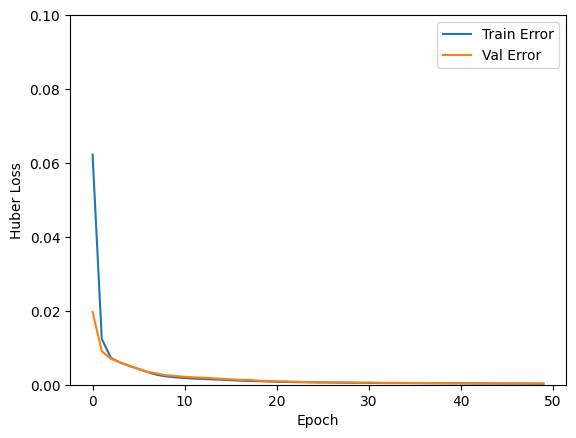

In [20]:
import matplotlib.pyplot as plt

def plot_history(history, loss):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel(f'{loss} Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
  plt.ylim([0,0.1])
  plt.legend()
  plt.show()

plot_history(history, "Huber")

13/13 [==============================] - 0s 948us/step


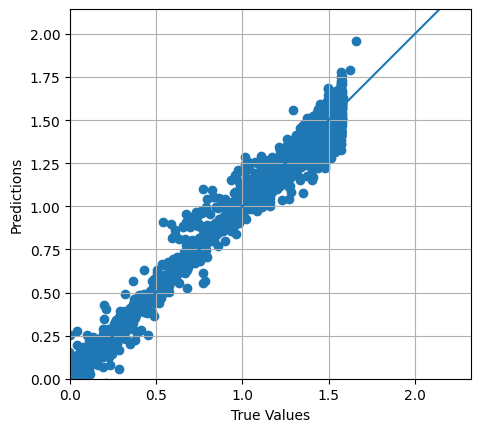

In [22]:
## Finalmente se hace uso de los datos de prueba para la predicción.
test_predictions = model.predict(X_test_scaled)
test_predictions_unscaled = scaler.inverse_transform(test_predictions)

## Se grafica la tabla de valores y predicciones.
plt.scatter(y_test, test_predictions_unscaled)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.plot([-100, 100], [-100, 100])
plt.grid()

Funcion para cargar un set de datos del ultimo conjunto recolectado

In [8]:
#Function to split the training data into X,y datasets
def load_dataset():
    file = open("training_dataset_20000_2023_1810_.pkl", "rb")
    training_data = pickle.load(file)
    training_df = pd.DataFrame(training_data)

    #List to store the name for every joint data column
    increments_columns = []
    prev_j_positions_columns = []
    prev_j_velocities_columns = []
    prev_j_forces_columns = []
    post_j_positions_columns = []
    post_j_velocities_columns = []
    post_j_forces_columns = []

    #Creates the name for every column
    num_joints = len(training_data[-1]["increments"])
    for joint_n in range(num_joints):
        #List to split inputs per joint
        joint_inc_col_name = "increments_" + str(joint_n)
        increments_columns.append(joint_inc_col_name)

        prev_joint_pos_col_name = "prev_j_positions_" + str(joint_n)
        prev_j_positions_columns.append(prev_joint_pos_col_name)

        prev_joint_vel_col_name = "prev_j_velocities_" + str(joint_n)
        prev_j_velocities_columns.append(prev_joint_vel_col_name)

        prev_joint_forc_col_name = "prev_j_forces_" + str(joint_n)
        prev_j_forces_columns.append(prev_joint_forc_col_name)
        #List to split outputs per joint
        post_joint_pos_col_name = "post_j_positions_" + str(joint_n)
        post_j_positions_columns.append(post_joint_pos_col_name)

        post_joint_vel_col_name = "post_j_velocities_" + str(joint_n)
        post_j_velocities_columns.append(post_joint_vel_col_name)

        post_joint_forc_col_name = "post_j_forces_" + str(joint_n)
        post_j_forces_columns.append(post_joint_forc_col_name)

    #Input columns per joint
    increments_df = pd.DataFrame(training_df['increments'].to_list())
    increments_df.columns = increments_columns
    prev_j_positions_df = pd.DataFrame(training_df['prev_j_positions'].to_list())
    prev_j_positions_df.columns = prev_j_positions_columns
    prev_j_velocities_df = pd.DataFrame(training_df['prev_j_velocities'].to_list())
    prev_j_velocities_df.columns = prev_j_velocities_columns
    prev_j_forces_df = pd.DataFrame(training_df['prev_j_forces'].to_list())
    prev_j_forces_df.columns = prev_j_forces_columns

    X_df = pd.concat([increments_df, prev_j_positions_df, 
                    training_df["prev_base_pos_x"], training_df["prev_base_pos_y"], training_df["prev_base_pos_z"], 
                    training_df["prev_base_ori_alpha"], training_df["prev_base_ori_beta"], training_df["prev_base_ori_gamma"]], 
                    axis="columns")

    #Output columns per joint
    post_j_positions_df = pd.DataFrame(training_df['post_j_positions'].to_list())
    post_j_positions_df.columns = post_j_positions_columns
    post_j_velocities_df = pd.DataFrame(training_df['post_j_velocities'].to_list())
    post_j_velocities_df.columns = post_j_velocities_columns
    post_j_forces_df = pd.DataFrame(training_df['post_j_forces'].to_list())
    post_j_forces_df.columns = post_j_forces_columns

    y_df = pd.concat([post_j_positions_df, 
                    training_df["post_base_pos_x"], training_df["post_base_pos_y"], training_df["post_base_pos_z"], 
                    training_df["post_base_ori_alpha"], training_df["post_base_ori_beta"], training_df["post_base_ori_gamma"]], 
                    axis="columns")

    return(X_df,y_df)

In [9]:
X, y =load_dataset()
# Se separan los datos de entrenmiento (80%) y los de prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, random_state=42
)

X_train.shape,X_test.shape

((80000, 22), (20000, 22))

In [10]:
y_test.shape

(20000, 14)

In [11]:
# Scaling de los datos 
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

In [12]:
model = Sequential()

# Capa de entrada con 22 unidades (correspondiente al número de entradas)
model.add(Dense(units=22, input_dim=22, activation='relu'))

# Capas ocultas con 64 unidades cada una
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=64, activation='relu'))

# Capa de salida con 14 unidades (correspondiente al número de salidas) y activación lineal
model.add(Dense(units=14, activation='linear'))

# Compilar el modelo con una función de pérdida adecuada para regresión
model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=1.0))

# Supongamos que X_train y y_train son tus datos de entrenamiento
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0031 - val_loss: 5.6589e-04
Epoch 2/50
2000/2000 [==============================] - 2s 1ms/step - loss: 2.6378e-04 - val_loss: 1.6785e-04
Epoch 3/50
2000/2000 [==============================] - 2s 1ms/step - loss: 1.4792e-04 - val_loss: 1.5460e-04
Epoch 4/50
2000/2000 [==============================] - 2s 1ms/step - loss: 1.2428e-04 - val_loss: 1.1042e-04
Epoch 5/50
2000/2000 [==============================] - 2s 1ms/step - loss: 1.1267e-04 - val_loss: 9.9801e-05
Epoch 6/50
2000/2000 [==============================] - 2s 1ms/step - loss: 1.0212e-04 - val_loss: 9.6324e-05
Epoch 7/50
2000/2000 [==============================] - 3s 1ms/step - loss: 9.3741e-05 - val_loss: 8.4913e-05
Epoch 8/50
2000/2000 [==============================] - 2s 1ms/step - loss: 8.5650e-05 - val_loss: 7.2498e-05
Epoch 9/50
2000/2000 [==============================] - 2s 1ms/step - loss: 8.0285e-05 - val_loss: 6.8020e-05
Epoch 10/50
20

In [13]:
y_pred = model.predict(X_test_scaled)

# Evaluar el modelo (por ejemplo, calculando el error cuadrado medio)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_scaled, y_pred)
print("Error cuadrado medio:", mse*100)

625/625 [==============================] - 1s 802us/step
Error cuadrado medio: 0.007365418707048402


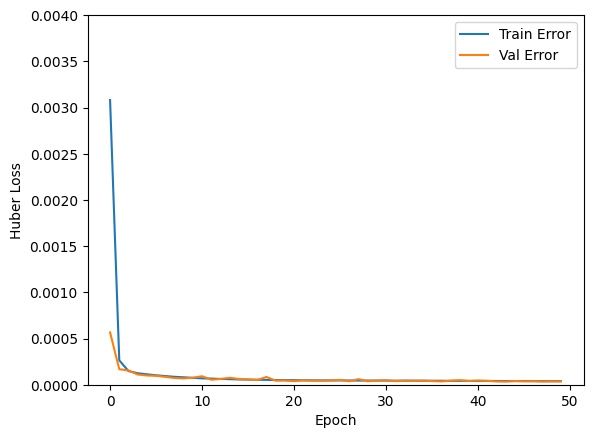

In [14]:
import matplotlib.pyplot as plt

def plot_history(history, loss):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel(f'{loss} Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
  plt.ylim([0,0.004])
  plt.legend()
  plt.show()

plot_history(history, "Huber")

In [15]:
## Finalmente se hace uso de los datos de prueba para la predicción.
test_predictions = model.predict(X_test_scaled)
test_predictions_unscaled = scaler.inverse_transform(test_predictions)

df_test_predictions_unscaled = pd.DataFrame(test_predictions_unscaled)
df_test_predictions_unscaled

  1/625 [..............................] - ETA: 9s

625/625 [==============================] - 1s 816us/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.361060,1.350883,-0.434005,1.277279,-0.288835,1.585160,-0.205522,1.458126,0.002473,0.028344,0.119469,-0.006083,-0.004068,0.078615
1,0.663704,1.520555,0.642579,1.599190,-0.212815,1.545878,-0.088623,1.581012,-0.018077,0.010905,0.118474,-0.002968,-0.003510,-0.181482
2,0.794223,1.524221,-0.622794,1.483361,-0.453613,0.086286,-0.279339,1.476122,-0.037470,0.012113,0.118789,-0.024188,0.030349,-0.173525
3,-0.796808,-1.550333,-0.848019,-1.512622,-0.724030,-0.222416,-0.350087,-1.027663,0.016417,0.016619,0.037671,0.023231,-0.002130,0.328078
4,0.413400,1.084602,-0.629857,1.436873,-1.212719,1.151131,-0.058448,1.578288,-0.012441,0.004187,0.119370,-0.012232,0.004196,0.105022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-0.545236,0.656051,-0.652174,1.057213,-0.673495,1.565592,1.160386,0.677712,0.029393,0.005523,0.117771,-0.016058,-0.018304,0.131289
19996,0.263884,-0.585051,-0.418639,-0.423736,0.136925,-0.788046,0.435973,-0.321630,0.018775,0.000349,0.042018,-0.006530,-0.015448,0.001480
19997,0.281340,-0.785415,0.393765,-1.462318,0.118383,-1.366725,-0.148105,-1.464723,-0.018779,0.001260,0.038732,-0.007799,-0.030515,-0.081063
19998,0.351599,-1.064506,-0.045089,-0.029321,-0.238928,-0.647001,0.044835,-0.679098,-0.002900,0.008763,0.042365,-0.007397,-0.015152,-0.007592


In [81]:
## Se grafica la tabla de valores y predicciones.
from sklearn.metrics import mean_squared_error

def plot_pred_vs_test(test, pred):
    columns = test.columns.tolist()
    mse_list = []
    rmse_list = []
    for column_num in range(len(columns)):
        plt.figure()
        plt.scatter(test.iloc[:,column_num], pred.iloc[:,column_num])
        mse = mean_squared_error(test.iloc[:,column_num], pred.iloc[:,column_num])
        mse_list.append(mse)
        rmse = np.sqrt(mean_squared_error(test.iloc[:,column_num], pred.iloc[:,column_num]))
        rmse_list.append(rmse)
        title = columns[column_num] + " - mse: " + str(round(mse,6))
        plt.title(title)
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        # Para tener una linea recta con la cual comparar los valores y que no altere
        # los limites de la figura se grafican los valores reales con ellos mismos
        plt.plot(test.iloc[:,column_num],test.iloc[:,column_num])
        plt.grid()
    print("Min mse: ", round(min(mse_list),6), " from: ", columns[mse_list.index(min(mse_list))])
    print("Max mse: ", round(max(mse_list),6), " from: ", columns[mse_list.index(max(mse_list))])
    print("Diff: ", round((max(mse_list) - min(mse_list))/max(mse_list)*100,6), "%")
    print("Min rmse: ", round(min(rmse_list),6), " from: ", columns[rmse_list.index(min(rmse_list))])
    print("Max rmse: ", round(max(rmse_list),6), " from: ", columns[rmse_list.index(max(rmse_list))])
    print("Diff: ", round((max(rmse_list) - min(rmse_list))/max(rmse_list)*100,6), "%")

Min mse:  1e-06  from:  post_base_pos_z
Max mse:  0.001114  from:  post_base_ori_gamma
Diff:  99.91465 %
Min rmse:  0.000975  from:  post_base_pos_z
Max rmse:  0.033382  from:  post_base_ori_gamma
Diff:  97.078531 %


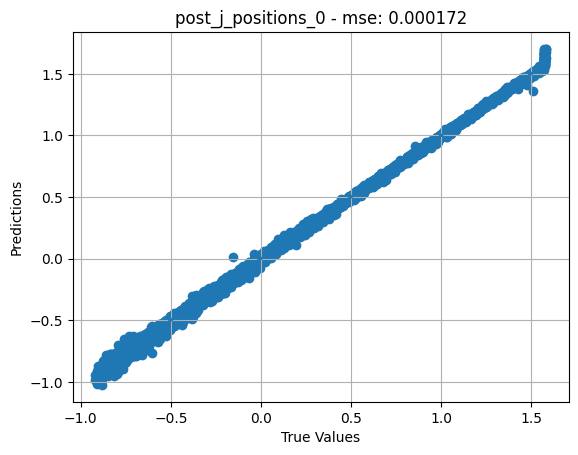

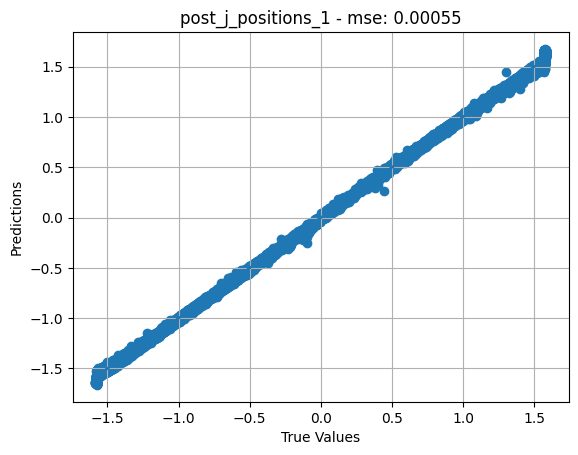

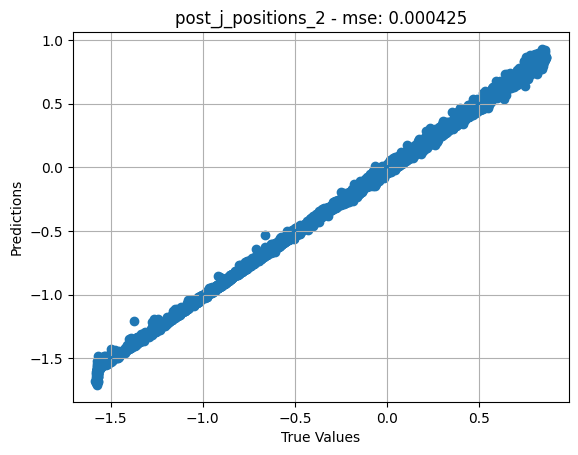

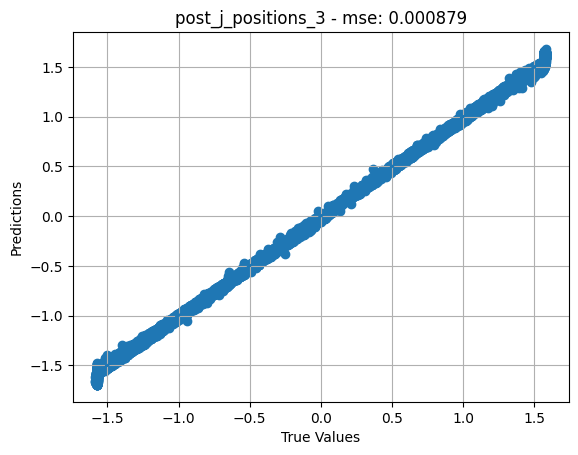

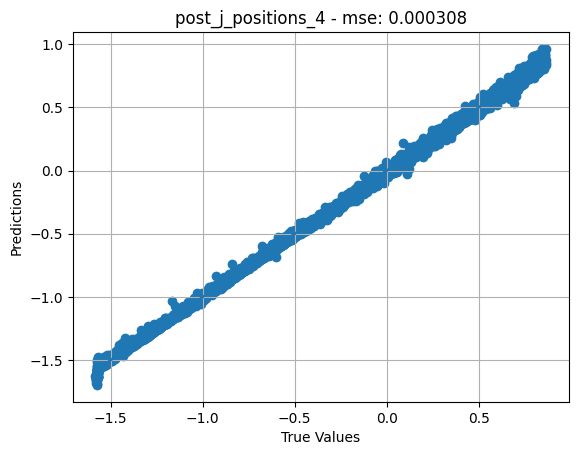

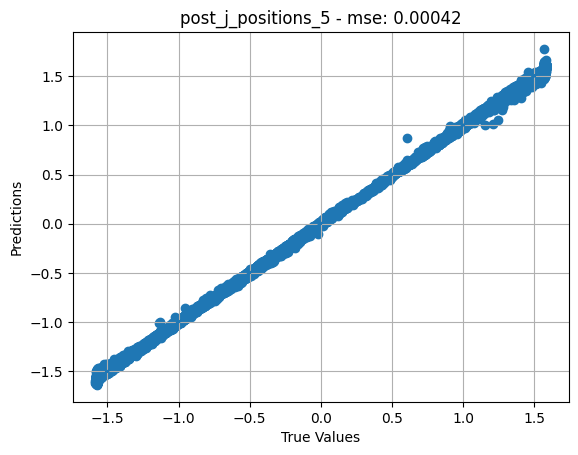

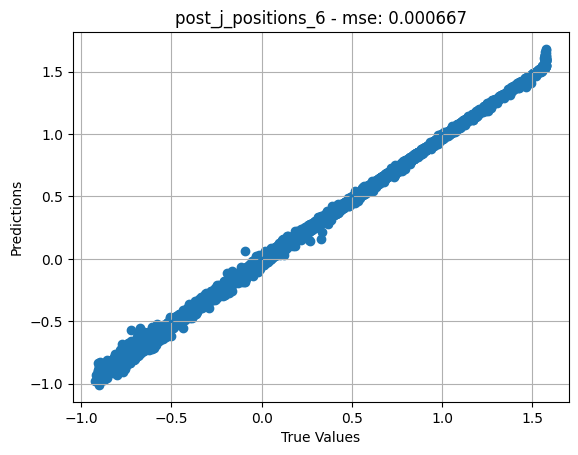

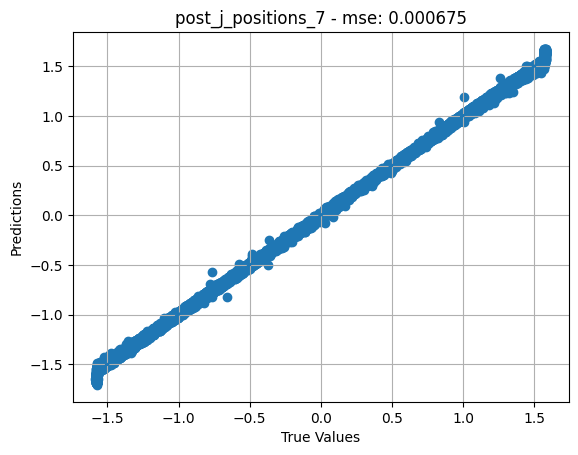

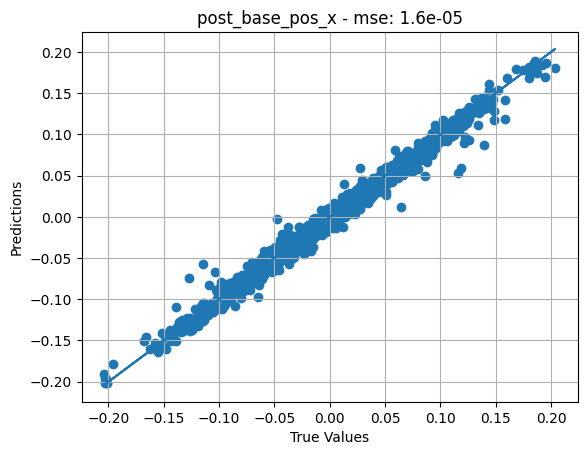

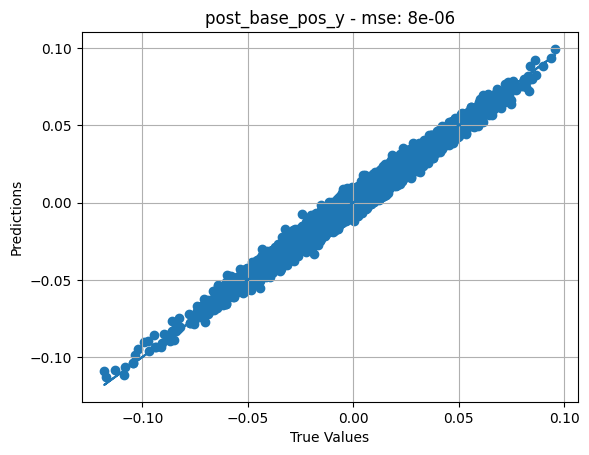

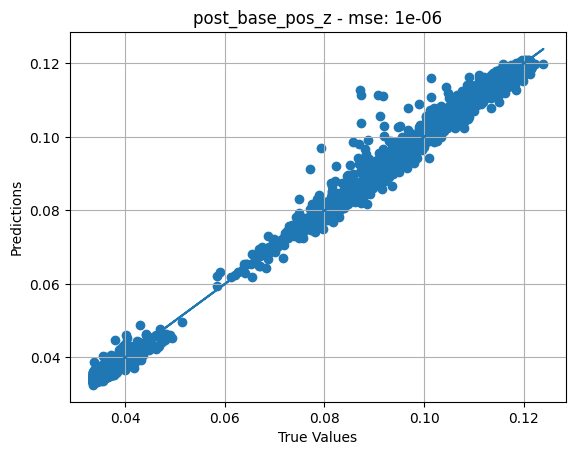

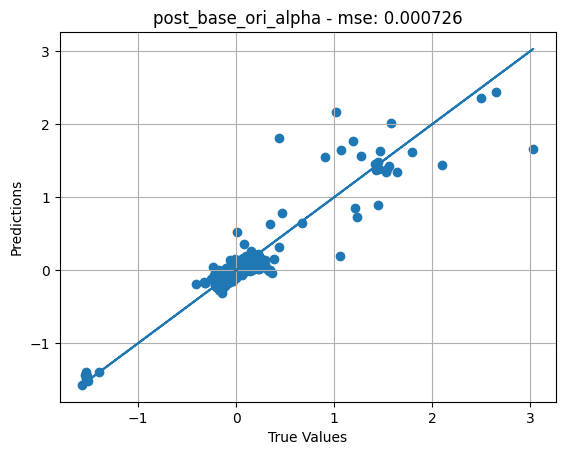

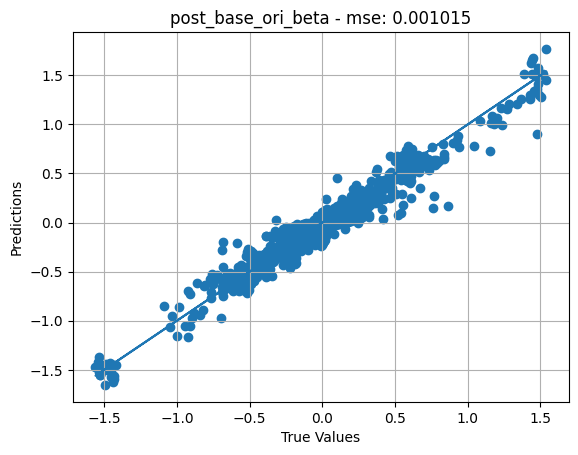

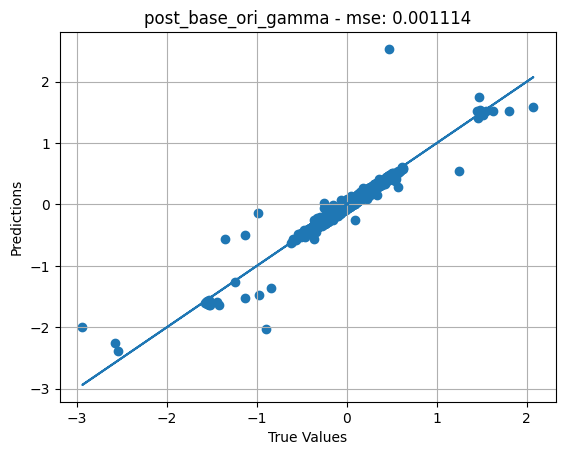

In [82]:
plot_pred_vs_test(y_test, df_test_predictions_unscaled)

#### Se desea revisar que los datos que se tienen cubran todo el espectro y permitan predecir los valores

In [45]:
file = open("training_dataset_20000_2023_1810_.pkl", "rb")
training_data = pickle.load(file)
training_df = pd.DataFrame(training_data)
#training_df.iloc[:,1]

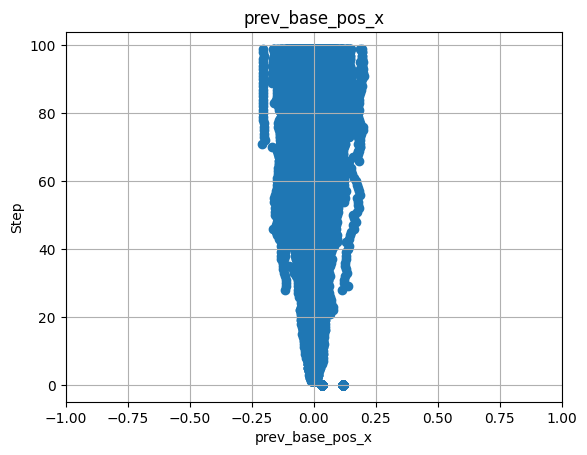

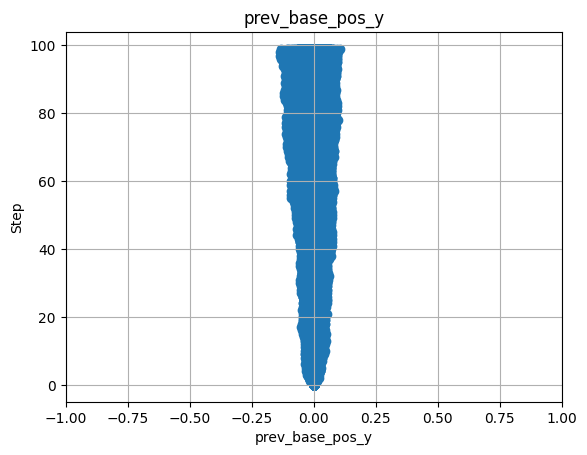

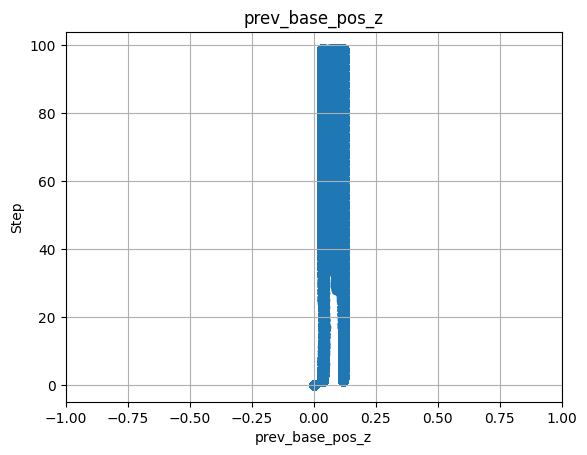

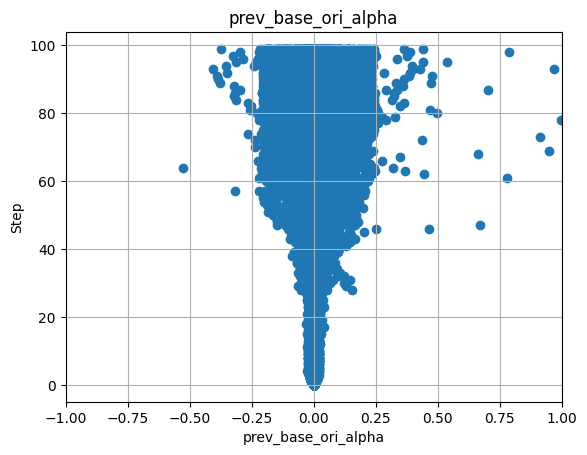

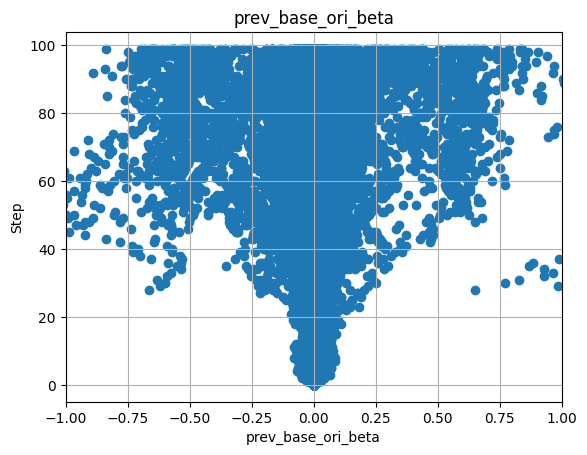

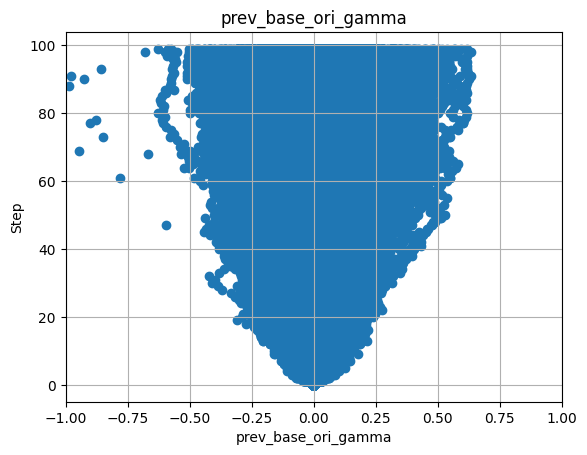

In [47]:
## Se grafica la tabla de valores de entrenamiento para ver que tanto varian y si se tiene el rango necesario para la base.
columns = X_train.columns.tolist()
for col in range(-6,0):
    plt.figure()
    plt.scatter(X.iloc[:,col],training_df.iloc[:,1])
    plt.title(columns[col])
    plt.ylabel('Step')
    plt.xlabel(columns[col])
    plt.xlim(-1,1)
    plt.grid()